# Juntando as tabelas nota de provas, nota de listas e submissoes em uma so

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from csv import reader

Import CSV

In [0]:
notap=pd.read_csv("https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/arquivosCSV/lopUsuarioNotaProva.csv")
notap=notap.drop(columns=["Unnamed: 0","nome","Unnamed: 0","ano"])

notal=pd.read_csv("https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/arquivosCSV/tabelaNotasListas.csv")
notal=notal.drop(columns=["descricaoTurma"])

sub=pd.read_csv("https://github.com/repitta/CienciaDeDadosEducacionais/raw/master/arquivosCSV/lopUseTurmasSubLista.csv")
sub=sub.drop(columns=["data","Unnamed: 0","idAluno","idLista","descricaoTurma","nome","quantidade"])


Substituindo valores nulors por zero

In [0]:
sub.replace(np.nan, 0, inplace=True)
notap.replace(np.nan, 0, inplace=True)
notal.replace(np.nan, 0, inplace=True)

Removendo as provas que contem video ou sao de testes

In [0]:
notap=notap.sort_values(by="idTurma")
notap["tituloProva"]=notap.tituloProva.astype(str)
notap=notap[(~notap["tituloProva"].str.contains("V")) & (~notap["tituloProva"].str.contains("este"))]

Fazendo consulta e dividindo por notas de primeira e segunda unidade, pegando a media e depois juntando 

In [0]:
notap1=notap.loc[(notap["tituloProva"].str.contains("Prova 01")) | (notap["tituloProva"].str.contains("Prova 1")) | (notap["tituloProva"].str.contains("Prova de Laboratório 1")),["idAluno","idTurma","matricula","notaProva","questoesFeitasProva","quantidadeProva","tituloProva"]]
notap1.rename(columns={"notaProva":"notaProva1","questoesFeitasProva":"questoesFeitasProva1","quantidadeProva":"quantidadeProva1","tituloProva":"tituloProva1"},inplace=True)
notap2=notap.loc[(notap["tituloProva"].str.contains("Prova 02")) | (notap["tituloProva"].str.contains("Prova 2")) | (notap["tituloProva"].str.contains("Prova de Laboratório 2")) | (notap["tituloProva"].str.contains("Segunda")) | (notap["tituloProva"].str.contains("2ª")),["matricula","notaProva","questoesFeitasProva","quantidadeProva","tituloProva"]]    
notap2.rename(columns={"notaProva":"notaProva2","questoesFeitasProva":"questoesFeitasProva2","quantidadeProva":"quantidadeProva2","tituloProva":"tituloProva2"},inplace=True)

notaProva=pd.merge(right = notap2, left = notap1, on="matricula", how="outer")
notaProva["mediaProvas"] = notaProva[["notaProva1","notaProva2"]].mean(axis=1)

notaProva.count()

idAluno                 797
idTurma                 797
matricula               908
notaProva1              797
questoesFeitasProva1    797
quantidadeProva1        797
tituloProva1            797
notaProva2              623
questoesFeitasProva2    623
quantidadeProva2        623
tituloProva2            623
mediaProvas             908
dtype: int64

Criando 5 DF para guardar o numero de questao submetidas de cada lista disponivel no LOP

In [0]:
sub["titulo"]=sub.titulo.astype(str)
sub=sub[(~sub["titulo"].str.contains("Prova"))]

sub1 = sub.loc[sub["titulo"].str.contains(" 1 ",na = False)]
sub1 = sub1.groupby(["matricula"])["questao"].count().reset_index().sort_values(by="matricula")
sub1.rename(columns={"questao":"qsub1"},inplace=True)

sub2 = sub.loc[sub["titulo"].str.contains(" 2 ",na = False)]
sub2 = sub2.groupby(["matricula"])["questao"].count().reset_index().sort_values(by="matricula")
sub2.rename(columns={"questao":"qsub2"},inplace=True)

sub3 = sub.loc[sub["titulo"].str.contains(" 3 ",na = False)]
sub3 = sub3.groupby(["matricula"])["questao"].count().reset_index().sort_values(by="matricula")
sub3.rename(columns={"questao":"qsub3"},inplace=True)

sub4 = sub.loc[(sub["titulo"].str.contains(" 4 ",na = False)) | (sub["titulo"].str.contains("4",na = False))]
sub4 = sub4.groupby(["matricula"])["questao"].count().reset_index().sort_values(by="matricula")
sub4.rename(columns={"questao":"qsub4"},inplace=True)

sub5 = sub.loc[sub["titulo"].str.contains(" 5 ",na = False)]
sub5 = sub5.groupby(["matricula"])["questao"].count().reset_index().sort_values(by="matricula")
sub5.rename(columns={"questao":"qsub5"},inplace=True)

sub1.head()

,matricula,qsub1
0,0.000000e+00,1625
1,2.014066e+09,1
2,2.014082e+09,7
3,2.014085e+09,10
4,2.015002e+09,8


Juntando as tabelas das listas

In [0]:
subm=pd.merge((pd.merge(pd.merge(sub1,sub2,on="matricula"),pd.merge(sub3,sub4,on="matricula"),on="matricula")),sub5,on="matricula")
subm.head()

,matricula,qsub1,qsub2,qsub3,qsub4,qsub5
0,0.000000e+00,1625,1464,910,243,170
1,2.014082e+09,7,6,7,18,14
2,2.015008e+09,2,19,16,9,8
3,2.015010e+09,37,22,42,26,21
4,2.015011e+09,18,22,18,26,18


Criando 3 campos irao conter a quantidade de sub das listas 1,2 e 3, outro para 4 e 5, e outro com o total

In [0]:
subm["qsubp1"] = subm[["qsub1","qsub2","qsub3"]].sum(axis=1)
subm["qsubp2"] = subm[["qsub4","qsub5"]].sum(axis=1)
subm["totalsub"] = subm[["qsub1","qsub2","qsub3","qsub4","qsub5"]].sum(axis=1)
subm.head()

,matricula,qsub1,qsub2,qsub3,qsub4,qsub5,qsubp1,qsubp2,totalsub
0,0.000000e+00,1625,1464,910,243,170,3999,413,4412
1,2.014082e+09,7,6,7,18,14,20,32,52
2,2.015008e+09,2,19,16,9,8,37,17,54
3,2.015010e+09,37,22,42,26,21,101,47,148
4,2.015011e+09,18,22,18,26,18,58,44,102


In [0]:
notaProva.head()

,idAluno,idTurma,matricula,notaProva1,questoesFeitasProva1,quantidadeProva1,tituloProva1,notaProva2,questoesFeitasProva2,quantidadeProva2,tituloProva2,mediaProvas
0,5991cb910be9d42f2f68b906,598e15296d8650eb27d52e3d,20170039453,72.0,5.0,5.0,Prova 1 - Turma 01 - 2017.2,14.285714,1.0,7.0,Prova 2 - Turma 01 - 2017.2,43.142857
1,5991cd793c13e92f349ee481,598e15296d8650eb27d52e3d,20170037234,96.0,5.0,5.0,Prova 1 - Turma 01 - 2017.2,95.142857,7.0,7.0,Prova 2 - Turma 01 - 2017.2,95.571429
2,5991cd76b3c8b42f3d5da404,598e15296d8650eb27d52e3d,20170044776,36.0,3.0,5.0,Prova 1 - Turma 01 - 2017.2,18.857143,4.0,7.0,Prova 2 - Turma 01 - 2017.2,27.428571
3,5991cd63b3c8b42f3d5da402,598e15296d8650eb27d52e3d,20170096736,24.0,3.0,5.0,Prova 1 - Turma 01 - 2017.2,52.285714,4.0,7.0,Prova 2 - Turma 01 - 2017.2,38.142857
4,59bee9b70da65738ad6b3a14,598e15296d8650eb27d52e3d,20170036390,92.0,5.0,5.0,Prova 1 - Turma 01 - 2017.2,90.285714,7.0,7.0,Prova 2 - Turma 01 - 2017.2,91.142857


Quantidade de questoes submetidas igual a 100% por aluno

In [0]:
igualACem1 = sub.loc[(sub["porcentagemAcerto"]==100) & ( (sub["titulo"].str.contains(" 1 ",na = False)) | (sub["titulo"].str.contains(" 2 ",na = False)) | (sub["titulo"].str.contains(" 3 ",na = False)) )]
igualACem2 = sub.loc[(sub["porcentagemAcerto"]==100) & ( (sub["titulo"].str.contains(" 4 ",na = False)) | (sub["titulo"].str.contains("4",na = False)) | (sub["titulo"].str.contains(" 5 ",na = False)))]
igualACem1 = igualACem1.groupby(["matricula"])["porcentagemAcerto"].count().reset_index().sort_values(by="matricula")
igualACem2 = igualACem2.groupby(["matricula"])["porcentagemAcerto"].count().reset_index().sort_values(by="matricula")
igualACem1.rename(columns={"porcentagemAcerto":"igualACeml123"},inplace=True)
igualACem2.rename(columns={"porcentagemAcerto":"igualACeml45"},inplace=True)
igualACem1.head()


,matricula,igualACeml123
0,0.000000e+00,3688
1,2.014082e+09,11
2,2.014085e+09,8
3,2.014085e+09,38
4,2.015002e+09,12


Juntando todas as tabelas e fazendo um dado final

In [0]:
table=pd.merge((pd.merge(pd.merge(notal,notaProva,on="matricula"),pd.merge(subm,igualACem1,on="matricula"),on="matricula")),igualACem2,on="matricula")
table=table.drop(columns=["Unnamed: 0"])
table.replace(np.nan, 0, inplace=True)
table.head()

,matricula,nome,ano,lab1,qLab1,lab2,qLab2,lab3,qLab3,lab4,qLab4,lab5,qLab5,exe1,qexe1,exe2,qexe2,exe3,qexe3,exe4,qexe4,exe4.1,qexe4.1,exe5,qexe5,idAluno,idTurma,notaProva1,questoesFeitasProva1,quantidadeProva1,tituloProva1,notaProva2,questoesFeitasProva2,quantidadeProva2,tituloProva2,mediaProvas,qsub1,qsub2,qsub3,qsub4,qsub5,qsubp1,qsubp2,totalsub,igualACeml123,igualACeml45
0,20170106538,ALEFF RAMON DA SILVA COSTA,2017.2,0.0,1.0,10.0,5.0,4.0,2.0,6.0,3.0,4.0,3.0,0.666667,2.0,6.755556,13.0,3.993333,7.0,4.375,7.0,0.0000,0.0,2.500,5.0,599b051d495fac076a06d3f5,598e15296d8650eb27d52e3d,52.0,5.0,5.0,Prova 1 - Turma 01 - 2017.2,0.000000,1.0,7.0,Prova 2 - Turma 01 - 2017.2,26.000000,5,28,10,10,12,43,22,65,33,18
1,20170039453,AMANDA,2017.2,10.0,5.0,10.0,5.0,10.0,5.0,10.0,5.0,10.0,5.0,7.333333,11.0,10.000000,18.0,10.000000,15.0,10.000,16.0,6.2500,5.0,10.000,16.0,5991cb910be9d42f2f68b906,598e15296d8650eb27d52e3d,72.0,5.0,5.0,Prova 1 - Turma 01 - 2017.2,14.285714,1.0,7.0,Prova 2 - Turma 01 - 2017.2,43.142857,16,26,21,27,23,63,50,113,63,50
2,20170044776,BRUNA ALICE OLIVEIRA DE BRUNA,2017.2,4.0,2.0,2.0,1.0,2.0,1.0,4.0,2.0,2.0,1.0,1.333333,2.0,0.555556,1.0,1.333333,2.0,3.125,5.0,0.0000,0.0,0.625,1.0,5991cd76b3c8b42f3d5da404,598e15296d8650eb27d52e3d,36.0,3.0,5.0,Prova 1 - Turma 01 - 2017.2,18.857143,4.0,7.0,Prova 2 - Turma 01 - 2017.2,27.428571,4,2,4,7,2,10,9,19,10,9
3,20170031473,BRUNA DE SOUZA PEREIRA,2017.2,10.0,5.0,10.0,5.0,4.0,2.0,4.0,2.0,0.0,2.0,3.333333,5.0,5.555556,10.0,4.666667,7.0,2.500,4.0,0.0000,0.0,0.000,2.0,599b0563d9b4c2079007acc9,598e15296d8650eb27d52e3d,44.0,5.0,5.0,Prova 1 - Turma 01 - 2017.2,47.571429,7.0,7.0,Prova 2 - Turma 01 - 2017.2,45.785714,10,25,12,6,4,47,10,57,46,6
4,20170032274,DAVI SIDRIM,2017.2,8.0,4.0,10.0,5.0,4.0,2.0,10.0,5.0,10.0,5.0,2.666667,4.0,3.888889,7.0,4.666667,7.0,4.375,7.0,5.4125,5.0,6.250,10.0,599b053410b11c07650122e9,598e15296d8650eb27d52e3d,32.0,4.0,5.0,Prova 1 - Turma 01 - 2017.2,80.857143,7.0,7.0,Prova 2 - Turma 01 - 2017.2,56.428571,8,12,12,32,15,32,47,79,30,32


# Analise da tabela completa

*   Dado que voce fez x questoes na lista voce vai fazer quantas na prova
*   Dado que voce tirou x nos exercicios quanto voce vai tirar na prova
*   Dado que voce tirou y nos laboratorios quanto voce vai tirar na prova






In [0]:
sns.set(style="whitegrid")

Grafico nota na prova1 x quantidade de questoes submetidas nas listas 1,2,3

Analise 1: se voce nao faz o minimo de 25 questoes voce nao consegue tirar 10

Analise 2: pra voce tirar 10 o grafico mostra que voce deve fazer entre 20 a 60 questoes

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


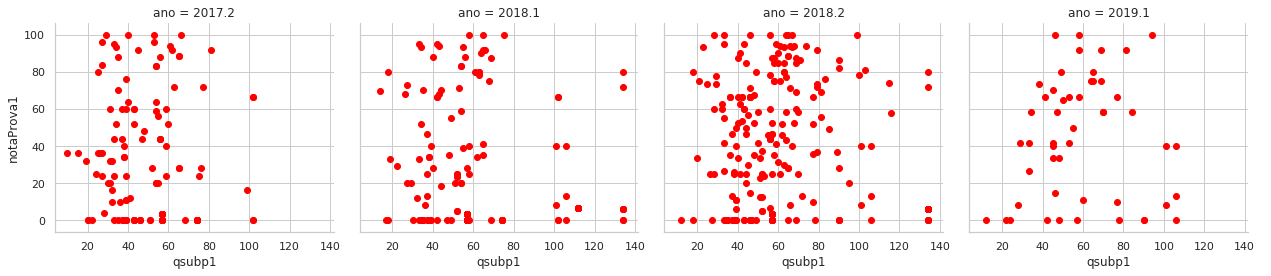

In [0]:
x = sns.FacetGrid(table,col="ano",margin_titles=False,size=4,aspect=1.1,col_wrap=4)
x = (x.map(plt.scatter, "qsubp1","notaProva1",color="red").add_legend())

Grafico nota na prova2 x quantidade de questoes submetidas nas listas 4,5

Analise 1: se voce nao faz o minimo de 10 questoes voce nao consegue tirar 10

Analise 2: pra voce tirar 10 o grafico mostra que voce deve fazer entre 15 a 40 questoes

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


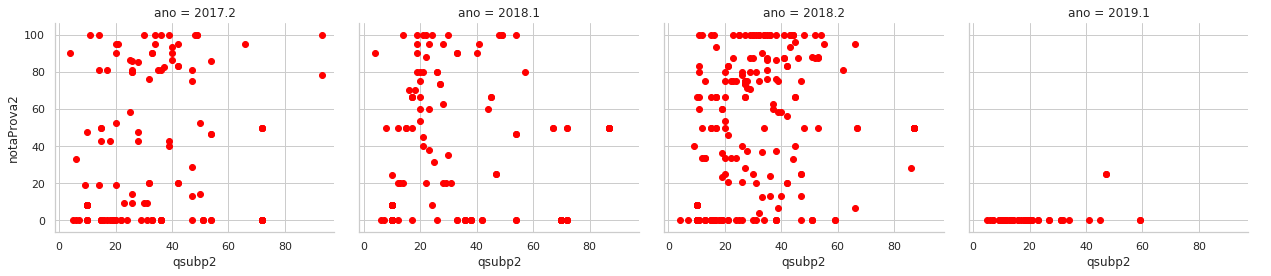

In [0]:
x = sns.FacetGrid(table,col="ano",margin_titles=False,size=4,aspect=1.1,col_wrap=4)
x = (x.map(plt.scatter, "qsubp2","notaProva2",color="red").add_legend())

Como estao distribuidas as notas da prova 1 ao longo dos 4 semestres

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


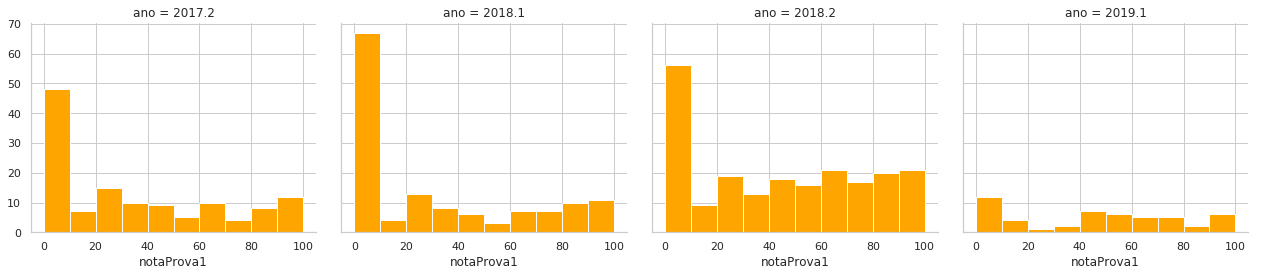

In [0]:
x = sns.FacetGrid(table,col="ano",margin_titles=False,size=4,aspect=1.1,col_wrap=4)
x = (x.map(plt.hist,"notaProva1",color="orange").add_legend())

Como estao distribuidas as notas da prova 2 ao longo dos 4 semestres

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


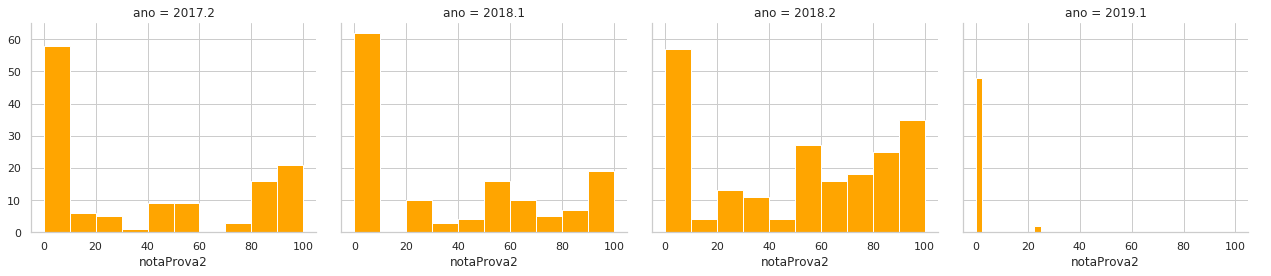

In [0]:
x = sns.FacetGrid(table,col="ano",margin_titles=False,size=4,aspect=1.1,col_wrap=4)
x = (x.map(plt.hist,"notaProva2",color="orange").add_legend())

Grafico quantidade de 100% nas listas x nota p1

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


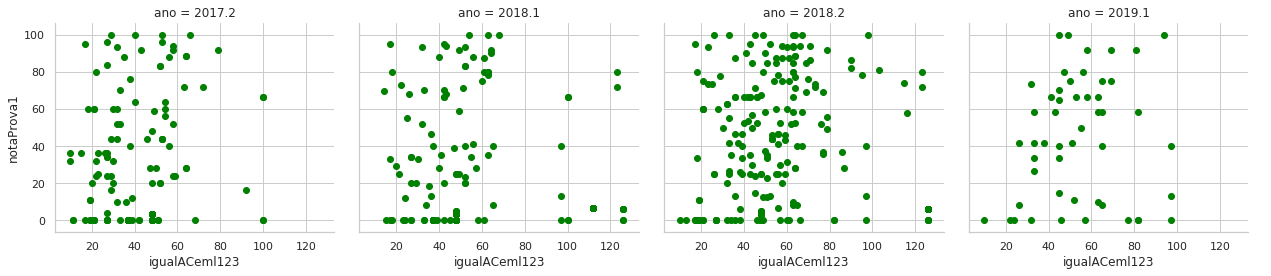

In [0]:
x = sns.FacetGrid(table,col="ano",margin_titles=False,size=4,aspect=1.1,col_wrap=4)
x = (x.map(plt.scatter, "igualACeml123","notaProva1",color="green").add_legend())

Grafico quantidade de 100% nas listas x nota p2

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


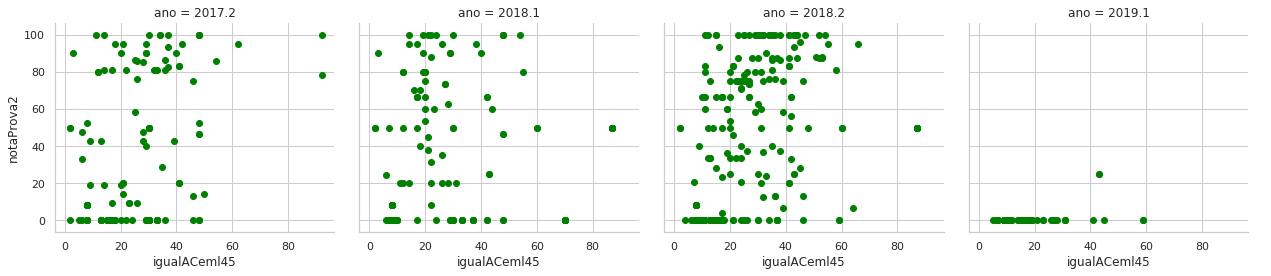

In [0]:
x = sns.FacetGrid(table,col="ano",margin_titles=False,size=4,aspect=1.1,col_wrap=4)
x = (x.map(plt.scatter, "igualACeml45","notaProva2",color="green").add_legend())

Grafico Media Provas x Quantidade total de questoes submetidas

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


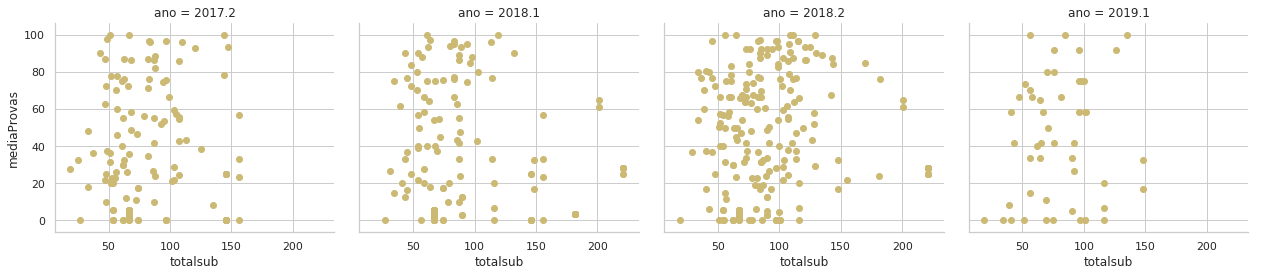

In [0]:
x = sns.FacetGrid(table,col="ano",margin_titles=False,size=4,aspect=1.1,col_wrap=4)
x = (x.map(plt.scatter, "totalsub","mediaProvas",color="y").add_legend())
#x = (x.map(sns.jointplot, "totalsub","mediaProvas",color="y",kind="reg").add_legend())

[link text](https:// [link text](https:// [link text](https:// [link text](https://))))No Submissao na prova1 x No submissao nas listas 123




/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


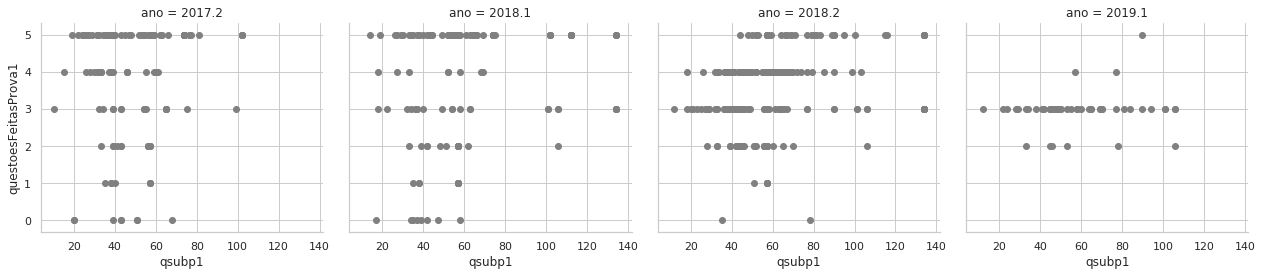

In [0]:
x = sns.FacetGrid(table,col="ano",margin_titles=False,size=4,aspect=1.1,col_wrap=4)
x = (x.map(plt.scatter, "qsubp1","questoesFeitasProva1",color="gray").add_legend())



No Submissao na prova2 x No submissao nas listas 45

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


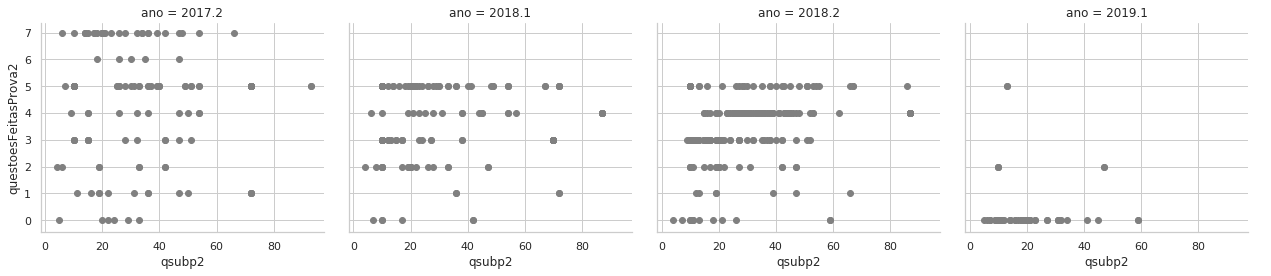

In [0]:
x = sns.FacetGrid(table,col="ano",margin_titles=False,size=4,aspect=1.1,col_wrap=4)
x = (x.map(plt.scatter, "qsubp2","questoesFeitasProva2",color="gray").add_legend())

Quantidade de submetidas dado que tirou 7 na prova 2018.2

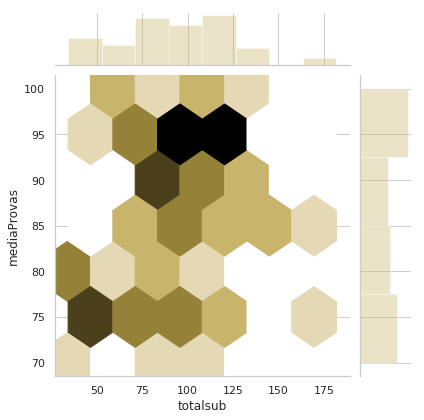

In [0]:
#a=table.loc[table["mediaProvas"]>=70.0,["totalsub","mediaProvas"]]
b=table.loc[(table["mediaProvas"]>=70.0) & (table["ano"]==2018.2),["totalsub","mediaProvas"]]

sns.jointplot(b["totalsub"],b["mediaProvas"],color="y",kind="hex")


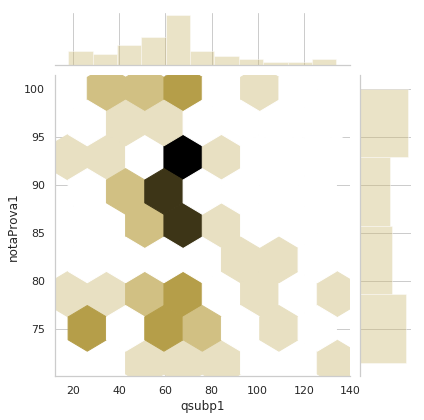

In [0]:
b=table.loc[(table["notaProva1"]>=70.0) & (table["ano"]==2018.2),["qsubp1","notaProva1"]]
sns.jointplot(b["qsubp1"],b["notaProva1"],color="y",kind="hex")


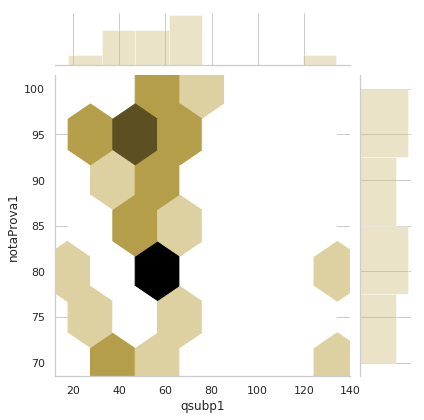

In [0]:
b=table.loc[(table["notaProva1"]>=70.0) & (table["ano"]==2018.1),["qsubp1","notaProva1"]]
sns.jointplot(b["qsubp1"],b["notaProva1"],color="y",kind="hex")

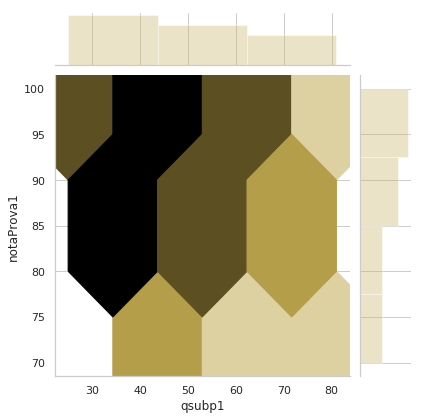

In [0]:
b=table.loc[(table["notaProva1"]>=70.0) & (table["ano"]==2017.2),["qsubp1","notaProva1"]]
sns.jointplot(b["qsubp1"],b["notaProva1"],color="y",kind="hex")

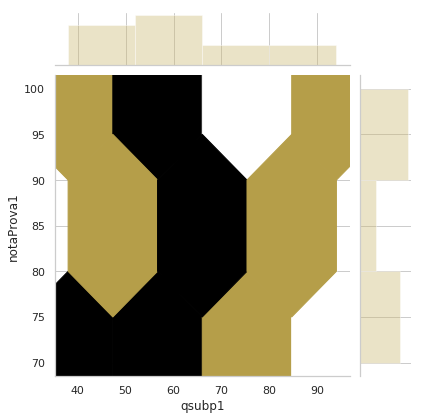

In [0]:
b=table.loc[(table["notaProva1"]>=70.0) & (table["ano"]==2019.1),["qsubp1","notaProva1"]]
sns.jointplot(b["qsubp1"],b["notaProva1"],color="y",kind="hex")

media ao longo dos anos

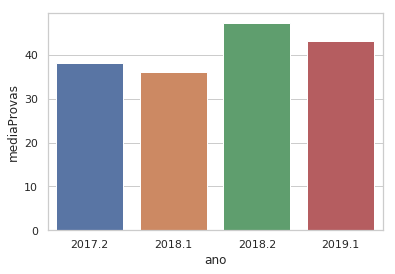

In [0]:
b=table
a = b.groupby(["ano"])["mediaProvas"].mean().reset_index().sort_values(by="ano")
sns.barplot(a["ano"],a["mediaProvas"])
sns.set(rc={'figure.figsize':(5.7,5.27)})

Por semestre, total de submissao  x media de prova maiores que 50

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


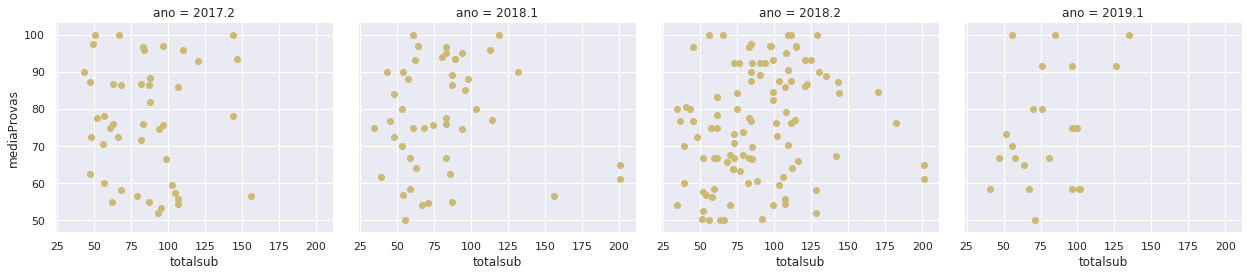

In [0]:
b=table.loc[table["mediaProvas"]>=50.0,["ano","totalsub","mediaProvas"]]
x = sns.FacetGrid(b,col="ano",margin_titles=False,size=4,aspect=1.1)
x = x.map(plt.scatter,"totalsub","mediaProvas",color="y")

Por semestre, total de submissao x media de prova menores que 50

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


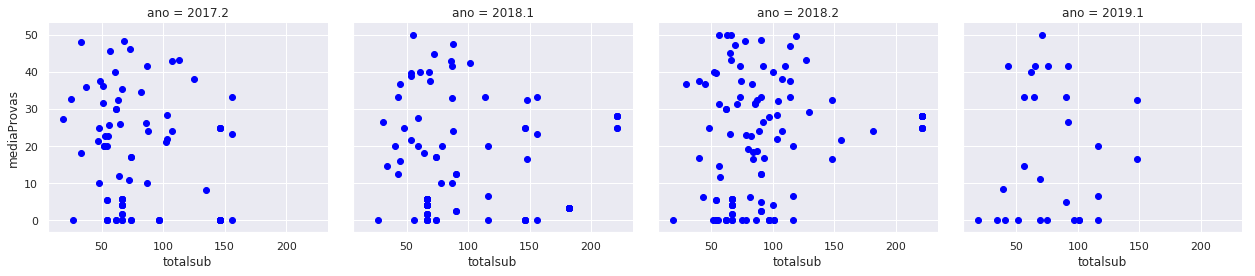

In [0]:
b=table.loc[table["mediaProvas"]<=50.0,["ano","totalsub","mediaProvas"]]
x = sns.FacetGrid(b,col="ano",margin_titles=False,size=4,aspect=1.1)
x = x.map(plt.scatter,"totalsub","mediaProvas",color="blue")

Grafico media do semestre na P1 X por semestre

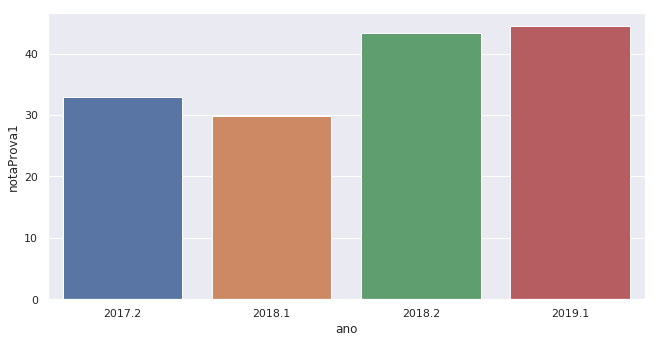

In [0]:
b=table
a = b.groupby(["ano"])["notaProva1"].mean().reset_index().sort_values(by="ano")
sns.barplot(a["ano"],a["notaProva1"])
sns.set(rc={'figure.figsize':(10.7,5.27)})

Grafico media do semestre na P2 X por semestre

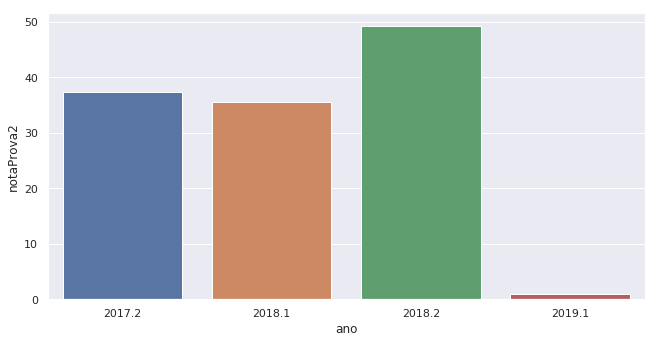

In [0]:
b=table
a = b.groupby(["ano"])["notaProva2"].mean().reset_index().sort_values(by="ano")
sns.barplot(a["ano"],a["notaProva2"])
sns.set(rc={'figure.figsize':(10.7,5.27)})

Numero de submissoes

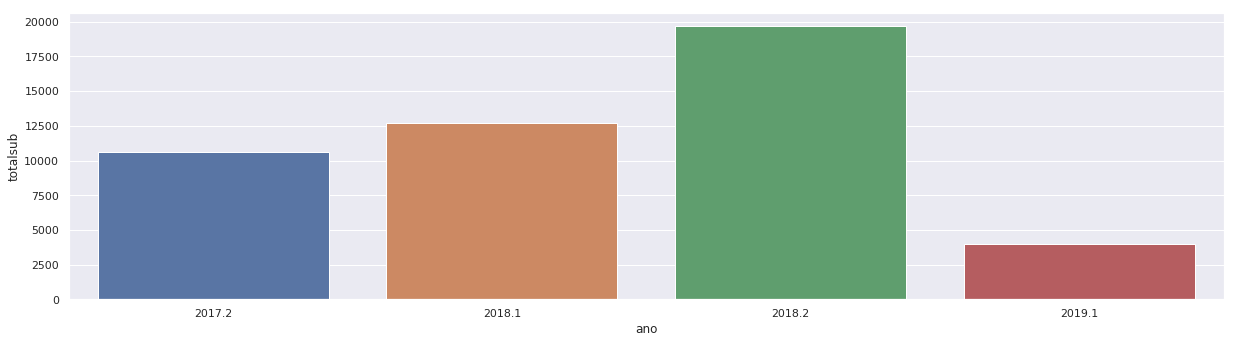

In [0]:
b=table
a = b.groupby(["ano"])["totalsub"].sum().reset_index().sort_values(by="ano")
sns.barplot(a["ano"],a["totalsub"])
sns.set(rc={'figure.figsize':(20.7,5.27)})

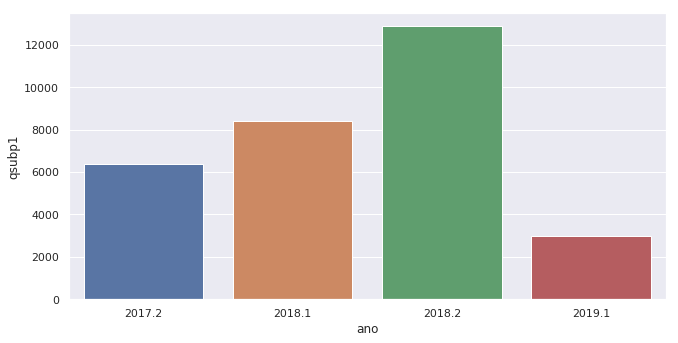

In [0]:
b=table
a = b.groupby(["ano"])["qsubp1"].sum().reset_index().sort_values(by="ano")
sns.barplot(a["ano"],a["qsubp1"])
sns.set(rc={'figure.figsize':(10.7,5.27)})


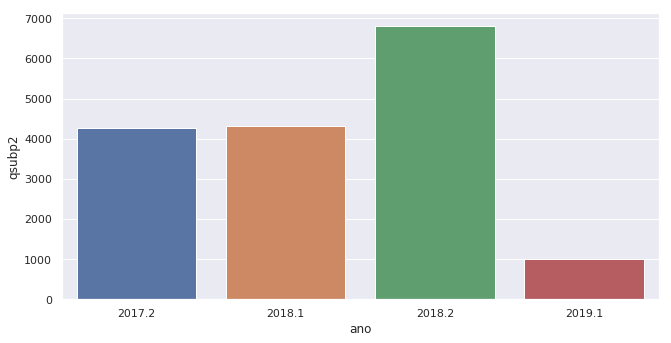

In [0]:
b=table
a = b.groupby(["ano"])["qsubp2"].sum().reset_index().sort_values(by="ano")
sns.barplot(a["ano"],a["qsubp2"])
sns.set(rc={'figure.figsize':(10.7,5.27)})


Quantidade de questoes iguais a 100 ao longo dos semestres nas listas 123

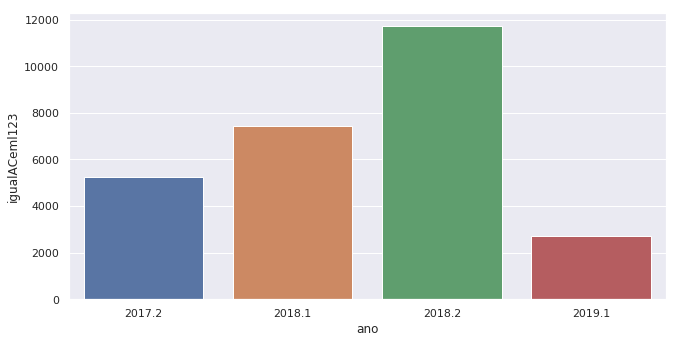

In [0]:
b=table
a = b.groupby(["ano"])["igualACeml123"].sum().reset_index().sort_values(by="ano")
sns.barplot(a["ano"],a["igualACeml123"])
sns.set(rc={'figure.figsize':(10.7,5.27)})

Quantidade de questoes iguais a 100 ao longo dos semestres nas listas 45

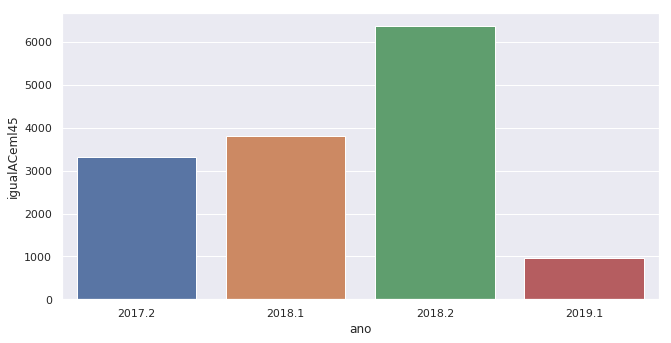

In [0]:
b=table
a = b.groupby(["ano"])["igualACeml45"].sum().reset_index().sort_values(by="ano")
sns.barplot(a["ano"],a["igualACeml45"])
sns.set(rc={'figure.figsize':(10.7,5.27)})

Grafico numero de alunos por semestre na plataforma lop

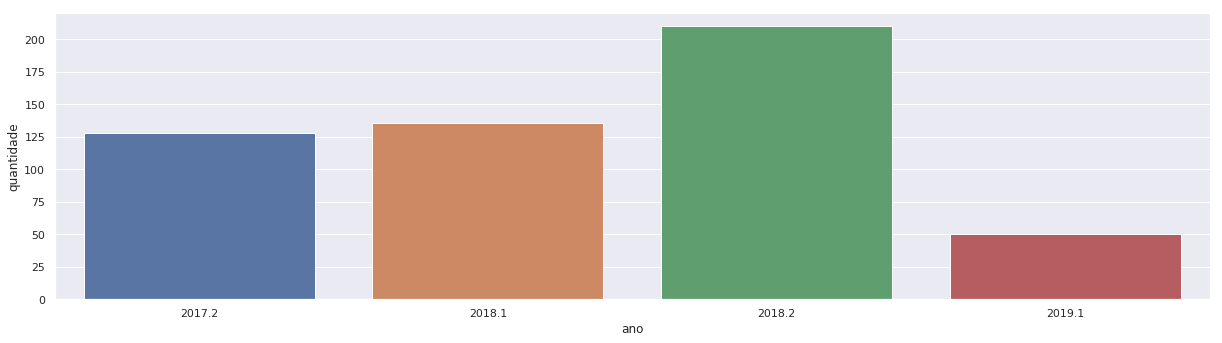

In [0]:
b=table
a = b.groupby(["ano"])["idAluno"].count().reset_index().sort_values(by="ano")
a.rename(columns={"idAluno":"quantidade"},inplace=True)
sns.barplot(a["ano"],a["quantidade"])
sns.set(rc={'figure.figsize':(20.7,5.27)})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


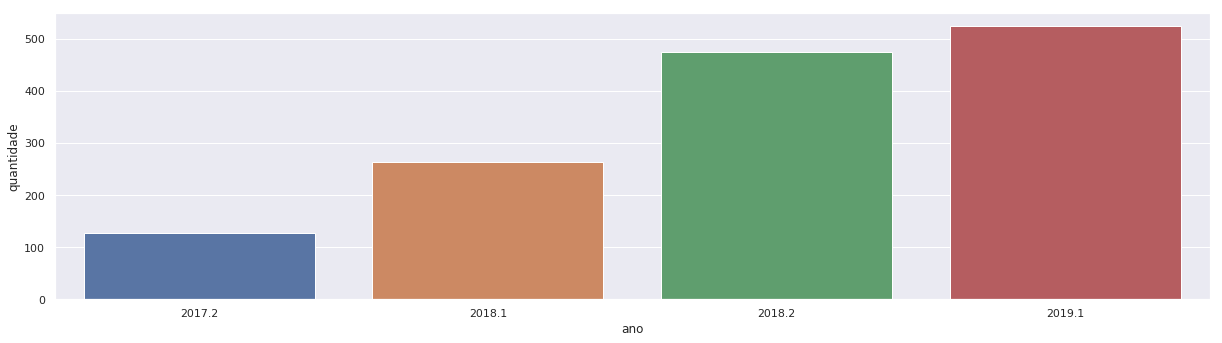

In [0]:
b=table
a = b.groupby(["ano"])["idAluno"].count().reset_index().sort_values(by="ano")
a.rename(columns={"idAluno":"quantidade"},inplace=True)
a["quantidade"][3]=a["quantidade"].sum()
a["quantidade"][2]=a["quantidade"][0]+a["quantidade"][1]+a["quantidade"][2]
a["quantidade"][1]=a["quantidade"][0]+a["quantidade"][1]
a.head()
sns.barplot(a["ano"],a["quantidade"])
sns.set(rc={'figure.figsize':(20.7,5.27)})

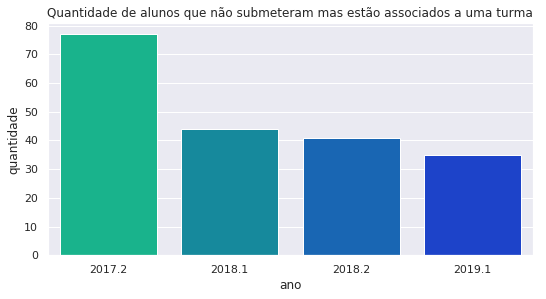

In [0]:
sub["idTurma"] = sub["idTurma"].dropna()
sTurma = sub.loc[sub["questao"].isna(),["ano","idTurma"]]
sTurma = sTurma.groupby("ano")["idTurma"].count().reset_index().sort_values(by="ano")
sTurma.rename(columns={"idTurma":"quantidade"},inplace=True)
sns.barplot("ano","quantidade",data=sTurma,palette="winter_r").set_title("Quantidade de alunos que não submeteram mas estão associados a uma turma")
sns.set(rc={'figure.figsize':(6.7,4.27)})

Distribuicao de notas por n submissao em 17.2

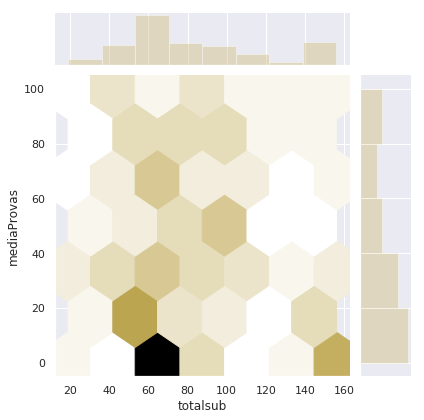

In [0]:
b=table.loc[table["ano"]==2017.2,["totalsub","mediaProvas"]]
sns.jointplot(b["totalsub"],b["mediaProvas"],color="y",kind="hex")
#x.set_xlabels("Número total de submissões")
#x.set_ylabels("Media das provas 1 e 2")




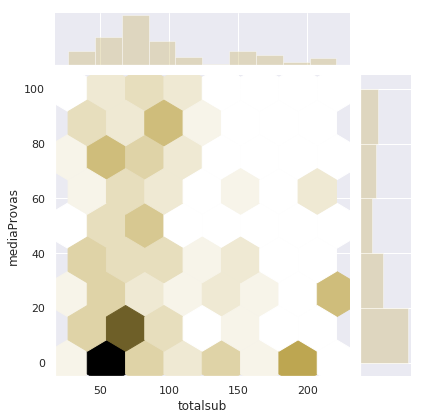

In [0]:
b=table.loc[table["ano"]==2018.1,["totalsub","mediaProvas"]]
sns.jointplot(b["totalsub"],b["mediaProvas"],color="y",kind="hex")

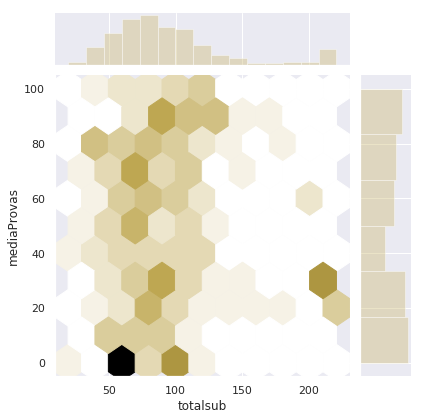

In [0]:
b=table.loc[table["ano"]==2018.2,["totalsub","mediaProvas"]]
sns.jointplot(b["totalsub"],b["mediaProvas"],color="y",kind="hex")

In [0]:
g = sns.catplot(x="class", y="survived", hue="sex", data=titanic,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

Grafico numero de aprovados e reprovados

Numero de alunos que "fizeram" a prova mas nao submeteram

# BIA

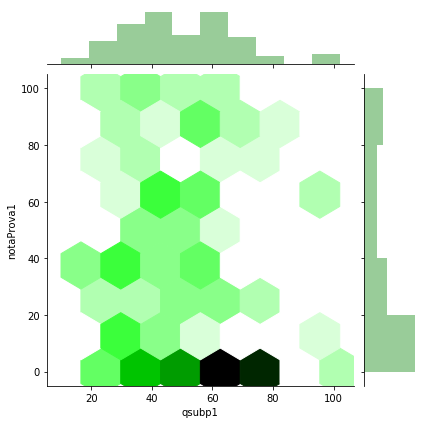

In [0]:
b=table.loc[table["ano"]==2017.2,["qsubp1","notaProva1"]]
sns.jointplot(b["qsubp1"],b["notaProva1"],color="g",kind="hex")

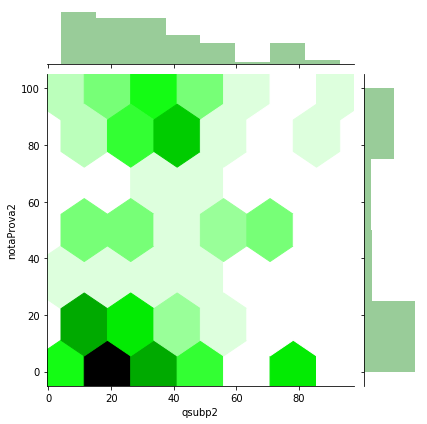

In [0]:
b=table.loc[table["ano"]==2017.2,["qsubp2","notaProva2"]]
sns.jointplot(b["qsubp2"],b["notaProva2"],color="g",kind="hex")

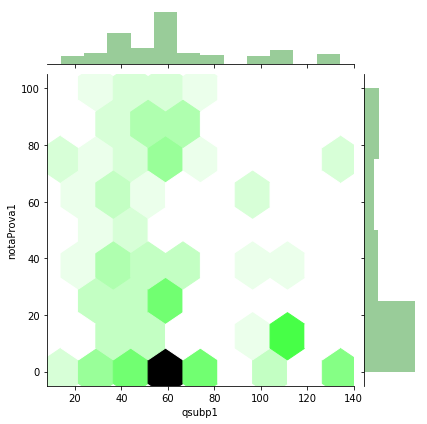

In [0]:
b=table.loc[table["ano"]==2018.1,["qsubp1","notaProva1"]]
sns.jointplot(b["qsubp1"],b["notaProva1"],color="g",kind="hex")

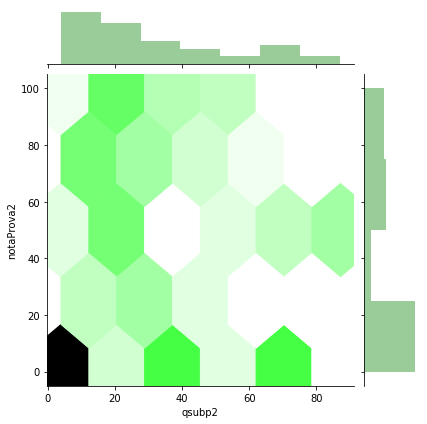

In [0]:
b=table.loc[table["ano"]==2018.1,["qsubp2","notaProva2"]]
sns.jointplot(b["qsubp2"],b["notaProva2"],color="g",kind="hex")

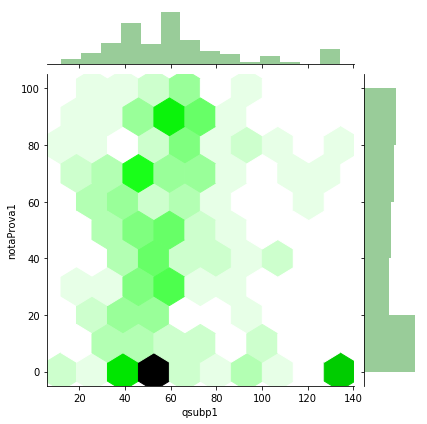

In [0]:
b=table.loc[table["ano"]==2018.2,["qsubp1","notaProva1"]]
sns.jointplot(b["qsubp1"],b["notaProva1"],color="g",kind="hex")

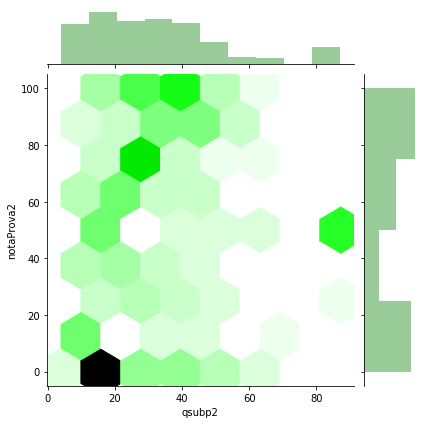

In [0]:
b=table.loc[table["ano"]==2018.2,["qsubp2","notaProva2"]]
sns.jointplot(b["qsubp2"],b["notaProva2"],color="g",kind="hex")

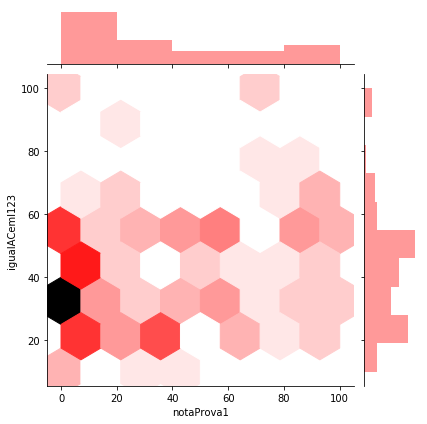

In [0]:
b=table.loc[table["ano"]==2017.2,["notaProva1","igualACeml123"]]

sns.jointplot(b["notaProva1"],b["igualACeml123"],color="red",kind="hex")


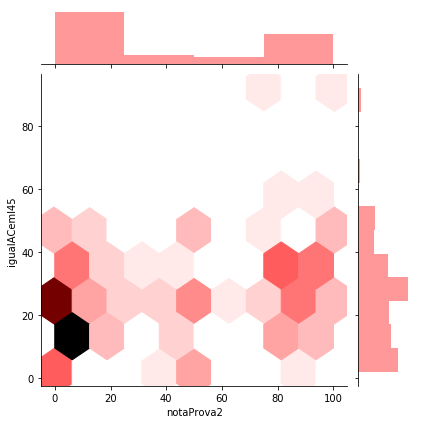

In [0]:
b=table.loc[table["ano"]==2017.2,["notaProva2","igualACeml45"]]

sns.jointplot(b["notaProva2"],b["igualACeml45"],color="red",kind="hex")

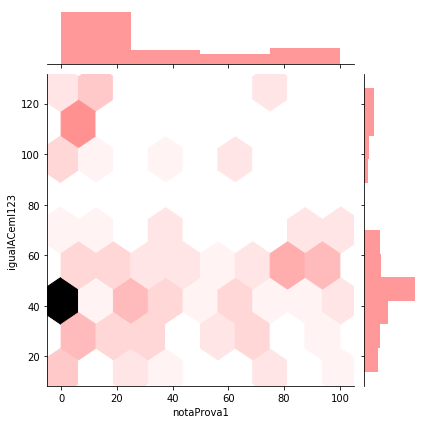

In [0]:
b=table.loc[table["ano"]==2018.1,["notaProva1","igualACeml123"]]

sns.jointplot(b["notaProva1"],b["igualACeml123"],color="red",kind="hex")


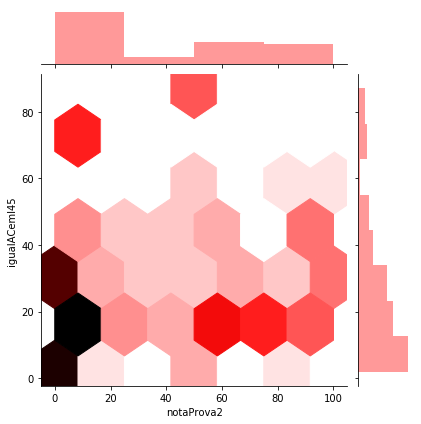

In [0]:
b=table.loc[table["ano"]==2018.1,["notaProva2","igualACeml45"]]

sns.jointplot(b["notaProva2"],b["igualACeml45"],color="red",kind="hex")


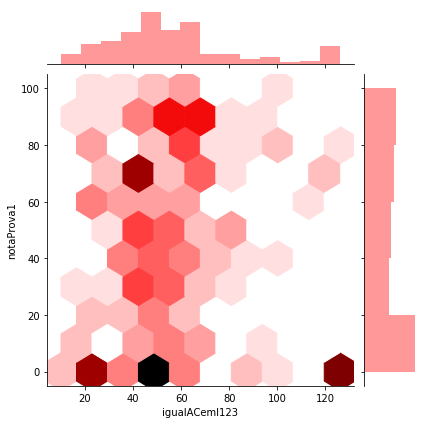

In [0]:
b=table.loc[table["ano"]==2018.2,["notaProva1","igualACeml123"]]

sns.jointplot(b["igualACeml123"],b["notaProva1"],color="red",kind="hex")




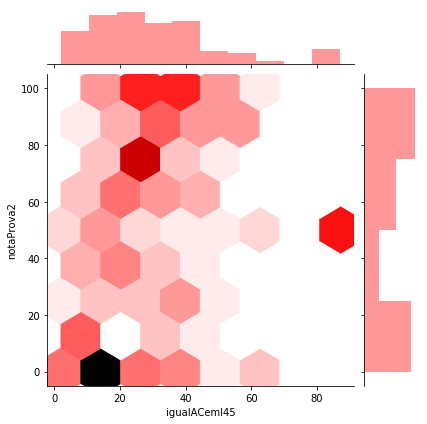

In [0]:
b=table.loc[table["ano"]==2018.2,["notaProva2","igualACeml45"]]

sns.jointplot(b["igualACeml45"],b["notaProva2"],color="red",kind="hex")

In [0]:
sns.boxplot(x="day", y="total_bill",
            hue="smoker", palette=["m", "g"],
            data=tips)

{'boxes': [<matplotlib.lines.Line2D at 0x7ff0c402c080>],
 'caps': [<matplotlib.lines.Line2D at 0x7ff0c402c898>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff0c40372b0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff0c402cf28>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff0c402c1d0>,
  <matplotlib.lines.Line2D at 0x7ff0c402c550>]}

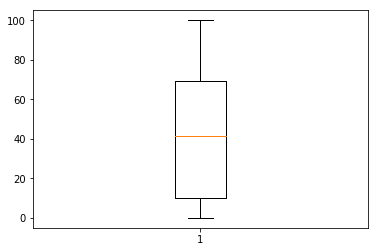

In [0]:
a=table.loc[table["ano"]==2019.1,["notaProva1"]]
plt.boxplot(a["notaProva1"])

{'boxes': [<matplotlib.lines.Line2D at 0x7ff0c40f7dd8>],
 'caps': [<matplotlib.lines.Line2D at 0x7ff0c40805f8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff0c4080fd0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff0c4080c88>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff0c40f7f28>,
  <matplotlib.lines.Line2D at 0x7ff0c40802b0>]}

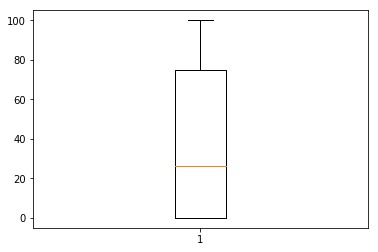

In [0]:
plt.boxplot(table["notaProva2"])

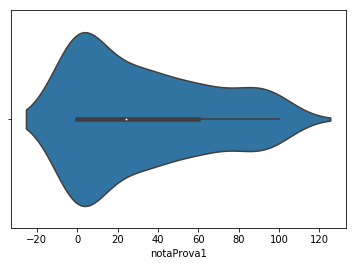

In [0]:
a=table.loc[table["ano"]==2017.2,["notaProva1"]]
sns.violinplot(a["notaProva1"])

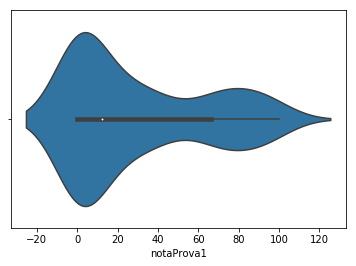

In [0]:
a=table.loc[table["ano"]==2018.1,["notaProva1"]]
sns.violinplot(a["notaProva1"])

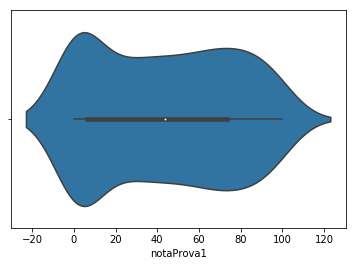

In [0]:
a=table.loc[table["ano"]==2018.2,["notaProva1"]]
sns.violinplot(a["notaProva1"])